In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Amazon Fine Foods Review/Reviews.csv")

In [4]:
df.shape

(568454, 10)

In [5]:
df.sample(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
243381,243382,B00305L330,A1ZFGTVFG7QK5B,T. Lambert,0,0,4,1271462400,Click,I love this stuff! I drink it before a workou...
464323,464324,B000UBD88A,A3A7CPMF9QL3KW,anabanana,1,1,5,1332806400,enjoyable,bought the senseo one cup coffee maker and thi...
240130,240131,B001VJ0B0I,AVXGN90BU95P8,"D. Buxman ""A Seeker of Truth""",0,0,4,1341532800,The Dog Likes it When Human Food isn't Available,I'm not a dog nutritionist. My dogs have alwa...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
# Dropping rows with reviews=3
print(df.Score.value_counts())
print()
temp=df.Score.value_counts()
print("Rows with scores=3,are approximately {}% of total available rows:".format( round((temp[3]/df.shape[0])*100 )))

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

Rows with scores=3,are approximately 8% of total available rows:


# we are discarding the rows having scores equal to 3

In [9]:
df.drop(labels=df[df["Score"]==3].index,inplace=True)
df.shape

(525814, 10)

# Labelling the scores as either positive or negative
if score is 1 or 2 labelling it as negative, else if score is 4 or 5 labelling it as positive 

In [10]:
def labels(x):
  if (x == 4)or(x==5):
    x=1
    return x
  else:
    x=0
    return x

df["label"]=df["Score"].apply(labels)

# EDA

**checking the balance of classes**

In [11]:
df.label.value_counts()

1    443777
0     82037
Name: label, dtype: int64

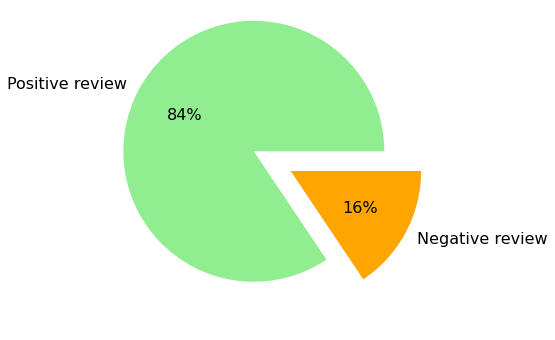

In [12]:
#https://www.delftstack.com/howto/seaborn/seaborn-pie-chart/
plt.figure(figsize=(8,6))
plt.pie(df.label.value_counts().values,labels=["Positive review","Negative review"],
        autopct='%0.0f%%',colors =["lightgreen","orange"],explode=[0.3,0.02],
        textprops = {'color': 'black','fontsize':16})
plt.show()

#Data Deduplication

In [13]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'label'],
      dtype='object')

Randomly picking one user Id from the below cell, then with the help of that user id, filtering rows.

In [14]:
df.UserId.sample(5)

280088    A1HGYLF2PVMBGR
460907    A1MCEXHSCES1HS
35305     A1U0EDW9Y40PAI
396745    A32QZZAP1HZLAY
276930    A2O5U7FUF8JA9Y
Name: UserId, dtype: object

In [15]:
df[df.UserId=="A1BVXU3QPVWY3R"]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,label
92566,92567,B001AHJ2D8,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
104330,104331,B000YSRK7E,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
105957,105958,B002DW0QG6,A1BVXU3QPVWY3R,avgpretty,2,2,5,1277510400,"Best ""small"" snack",Amazing! These little snacks are super tasty ...,1
167881,167882,B001AHL6CI,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
185353,185354,B001AHFVHO,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
241881,241882,B001AHJ2FQ,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
484824,484825,B00248EE4O,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
519864,519865,B000YSTIL0,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1


In [16]:
df[(df.ProfileName=="avgpretty")&(df.Time==1277510400)].sort_values(["ProductId"])

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,label
104330,104331,B000YSRK7E,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
519864,519865,B000YSTIL0,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
185353,185354,B001AHFVHO,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
92566,92567,B001AHJ2D8,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
241881,241882,B001AHJ2FQ,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
167881,167882,B001AHL6CI,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
484824,484825,B00248EE4O,A1BVXU3QPVWY3R,avgpretty,0,0,5,1277510400,Don't be fooled,"Oh my gosh! Who knew a ""chocolate"" chip would...",1
105957,105958,B002DW0QG6,A1BVXU3QPVWY3R,avgpretty,2,2,5,1277510400,"Best ""small"" snack",Amazing! These little snacks are super tasty ...,1


We found that there exists multiple rows for similar product, 
eg: we have chip available lets say ABC, while doing evaluation we found that multiple reviews exists for different flavours of same ABC chip, interestingly the same user have written same review at same time stamp. Which aint possible,

So we decided to drop such rows to avoid dupliction in our data

In [17]:
df.sort_values(by="ProductId", inplace=True)
df_temp=df.drop_duplicates(subset={"UserId",'ProfileName',"Time","Text"},keep="first")
temp=(df_temp.shape[0]/df.shape[0])*100
print("{}% of the data will still be remain if we drop the duplicate rows".format(round(temp,2)))

69.26% of the data will still be remain if we drop the duplicate rows


In [18]:
df.drop_duplicates(subset={"UserId",'ProfileName',"Time","Text"},keep="first",inplace=True)


After perform the operation of dropping duplicate rows, we can see in the below cell that duplicate rows are not in the dataset anymore.

In [19]:
df_temp[(df_temp.ProfileName=="avgpretty")&(df.Time==1277510400)]
del df_temp

In [20]:
df.shape

(364173, 11)

# checking for null values

In [21]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    1
Text                       0
label                      0
dtype: int64

In [22]:
# dropping null rows with null values
df.dropna(inplace=True)
df.shape

(364161, 11)

# Text Cleaning

In [23]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
stopword_corpus=set(stopwords.words("english"))
snow_stemmer = SnowballStemmer(language='english')

In [25]:
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
def get_stemmer(sen):
  #word_lst=word_tokenize(sen)
  #snow_stemmer = SnowballStemmer(language='english')
  word_lst=sen.split(" ")
  lst=[]
  for word in word_lst:
    if 2<len(word):
      if word not in stopword_corpus:
        if word.isalpha():
          stemmed=snow_stemmer.stem(word)
          lst.append(stemmed)
        else:
          pass
      else:
        pass
    else:
      pass 
  #---------------------------------------------------      
  del word_lst
  return (" ").join(lst)

In [27]:
def get_preprocessed(string):
  #replace anything with html tags, to blank space
  string=re.sub("<.*?>","",string)
  string=decontracted(string)
  #replace all the punctuations with space,except '
  string=re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]'," ",string)
  # by the execution of the above command we get multiple white spaces in our text, therefore we need to replace multiple spaces with single space, 
  #removing following and trailing spaces and convering to lowercase
  string= re.sub(" +", " ", string).lower().strip()
  sentance=get_stemmer(string)
  return sentance

In [28]:
# combining preprocessing "summary" and "text" and forming a new column named "preprocess_data"
summary=df["Summary"].apply(get_preprocessed)
text=df["Text"].apply(get_preprocessed)
df["preprocess_data"]=summary+" "+text

In [29]:
#dropping columns which are not needed for our analysis
df.drop(['ProductId',"UserId",'Id','ProfileName','ProfileName','HelpfulnessNumerator',"HelpfulnessDenominator","Score","Time","Summary","Text"],axis=1,inplace=True)

In [30]:
x=df["preprocess_data"]
y=df["label"]

#Splitting data into train and test dataset

In [43]:
x_train,x_test,y_train,y_test=train_test_split(x.values,y.values,test_size=0.30,stratify=y.values)

In [44]:
x_train.shape,x_test.shape

((254912,), (109249,))

In [45]:
y_train.shape,y_test.shape

((254912,), (109249,))

#Set 1 converting text data to vectors using tfidf() vectorizer

In [46]:
#text vectorizing
vec=TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=4000)
x_train_tfidf=vec.fit_transform(x_train)
x_test_tfidf=vec.transform(x_test)

#Set 2 converting text data to vectors using BOW Countvectorizer()

In [47]:
#text vectorizing
vec_2=CountVectorizer(ngram_range=(1,2),min_df=10,max_features=4000)
x_train_BOW=vec_2.fit_transform(x_train)
x_test_BOW=vec_2.transform(x_test)

# HyperParameter Tuning, Modeling our data, Confusion Matix, word cloud of top 50 Features

In [48]:
def get_Confusion_Matix(NB,x_test,y_test,y_pred):
  plot_confusion_matrix(NB,x_test,y_test,cmap='Blues_r',display_labels=["class_0","class_1"],values_format='d')
  plt.show()
  #-----------------------------------------------
  cf=confusion_matrix(y_test,y_pred)
  correctly=np.round((np.sum(np.diag(cf))/np.sum(cf))*100,2)
  print(cf[0])
  print("correctly classified points {}%".format(correctly))
  

In [49]:
def get_wordcloud(NB,vec_obj):
  # merging all feature names in the same order, as they were passed to Naive Bayes classifier.
  all_features=vec_obj.get_feature_names_out()
  all_features.shape
  idx=NB.feature_log_prob_[0,:].argsort()[::-1].tolist()
  negative_imp_features=all_features[idx][0:30]
  #-----------------------------------------------------------
  idx=NB.feature_log_prob_[1,:].argsort()[::-1].tolist()
  positive_imp_features=all_features[idx][0:30]
  #---------------Positive features------------------------
  print("Top 30 features to classify positve labels")
  cloud = WordCloud(background_color = "white",width=1600,height=800).generate(" ".join(positive_imp_features.tolist()))
  #cloud=cloud.generate_from_frequencies(positive_imp_features)
  plt.figure(figsize=(12,8))
  plt.imshow(cloud)
  plt.show()
  print()
  #---------------------------negative features-------------------------
  print("Top 30 features to classify Negative labels")
  cloud = WordCloud(background_color = "white",width=1600,height=800).generate(" ".join(negative_imp_features.tolist()))
  #cloud=cloud.generate_from_frequencies(positive_imp_features)
  plt.figure(figsize=(12,8))
  plt.imshow(cloud)
  plt.show()

In [50]:
def do_process(x_train,y_train,x_test,y_test,vec_obj):
  #-------------HyperParameter Tuning----------------------------

  NB=MultinomialNB(class_prior=[0.5,0.5])
  params={'alpha':[0.001,0.01,0.1,0.5,1,5,10,50,100,1000]}
  #params={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}
  random=RandomizedSearchCV(estimator=NB,param_distributions=params,cv=5,return_train_score=True,scoring="roc_auc",n_jobs=-1)
  random.fit(x_train,y_train)
  print(random.best_params_,random.best_score_)
  res=pd.DataFrame(random.cv_results_)
  res=res.sort_values(['param_alpha'])
  #res
  train_auc=res['mean_train_score']
  cv_auc=res['mean_test_score']
  alpha=res['param_alpha']
  #--------------------------Error Plot-----------------------
  plt.figure(figsize=(8,5))
  plt.plot(np.log10(alpha.tolist()), train_auc, label='Train AUC',color='red')
  plt.plot(np.log10(alpha.tolist()), cv_auc, label='CV AUC',color='green')
  plt.scatter(np.log10(alpha.tolist()), train_auc, label='Train AUC',color='darkred')
  plt.scatter(np.log10(alpha.tolist()), cv_auc, label='CV AUC',color="darkgreen")
  plt.xlabel("log(Hyperparameter Alpha)")
  plt.ylabel("AUC")
  plt.title("Error plot")
  plt.legend()
  plt.show()
  print()
  #---------------------Modeling our data-------------------------
  from sklearn.metrics import roc_curve, auc

  NB=MultinomialNB(alpha=random.best_params_['alpha'],class_prior = [0.5,0.5])
  NB.fit(x_train,y_train)
  train_pred=NB.predict_proba(x_train)[:,1]
  test_pred=NB.predict_proba(x_test)[:,1]
  #-----------predicting train data class labels-----------------
  y_pred=NB.predict(x_test)
  #-------------ROC_AUC,----------------------------------
  train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,train_pred)
  test_fpr, test_tpr, te_thresholds = roc_curve(y_test,test_pred)
  #------------------Plotting ROC_AUC Curve--------------------
  plt.figure(figsize=(8,5))
  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.title("ROC AUC Curve")
  plt.show()
  print()
  #-------------------------------------------------------
  
  #------------------Confusion Matix------------------
  get_Confusion_Matix(NB,x_test,y_test,y_pred)
  print()
  #------------------Word Cloud --------------------------
  get_wordcloud(NB,vec_obj)

  return auc(train_fpr, train_tpr),auc(test_fpr, test_tpr),random.best_params_['alpha']

# Conclusion 

{'alpha': 0.5} 0.9502176426577297


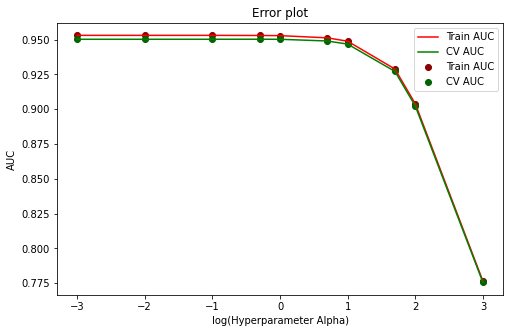

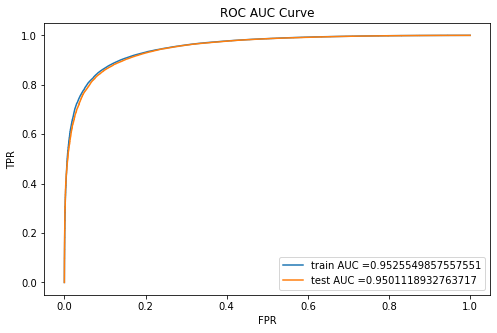

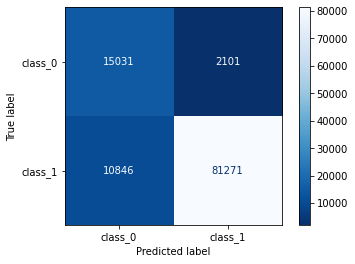

[15031  2101]
correctly classified points 88.15%

Top 30 features to classify positve labels


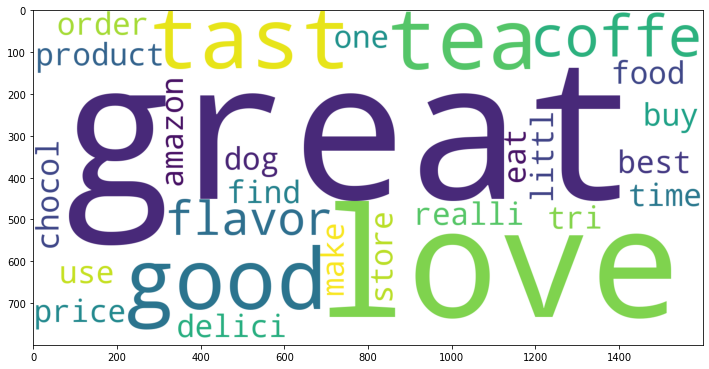


Top 30 features to classify Negative labels


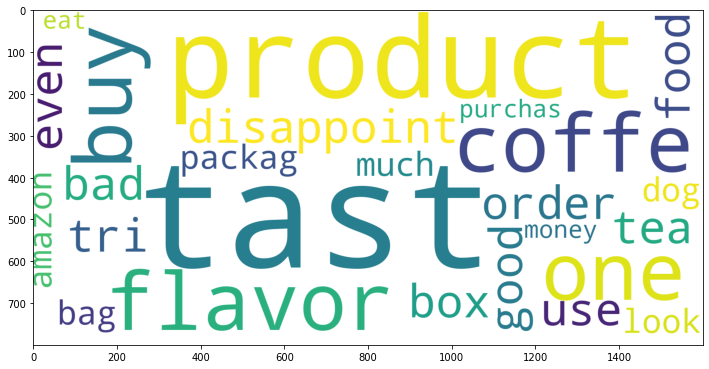

In [51]:
#Set-1 Term Frequency-Inverse Document Frequency
train_auc_tfidf, test_auc_tfidf, best_alpha_tfidf=do_process(x_train_tfidf, y_train, x_test_tfidf, y_test,vec)

{'alpha': 0.001} 0.9422550211274103


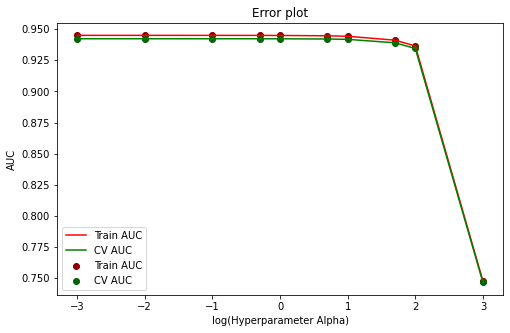

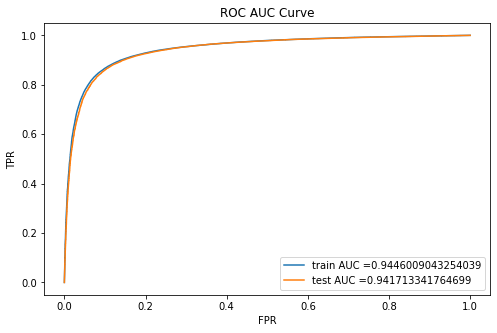

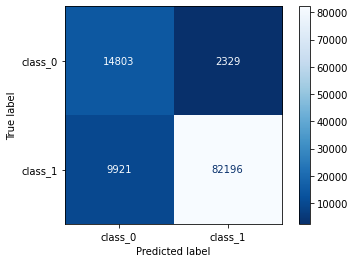

[14803  2329]
correctly classified points 88.79%

Top 30 features to classify positve labels


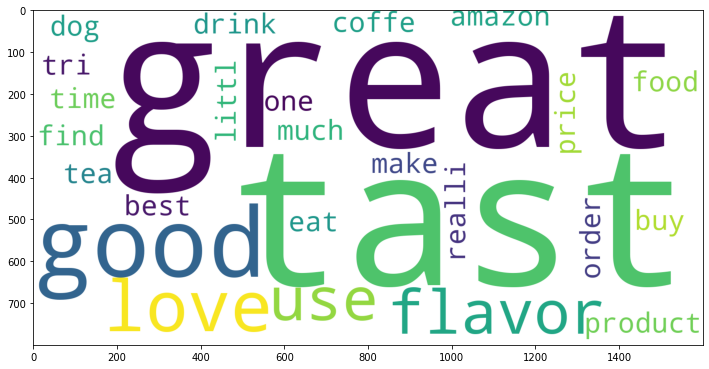


Top 30 features to classify Negative labels


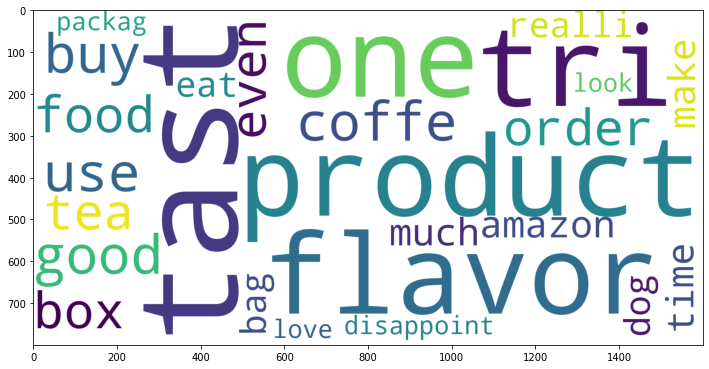

In [52]:
# SET-2  Bag of Words
train_auc_bow, test_auc_bow, best_alpha_bow=do_process(x_train_BOW, y_train, x_test_BOW, y_test,vec_2)

In [53]:
#Pretty Table
from prettytable import PrettyTable
Table=PrettyTable(["Vectorizer","Model","Test AUC","Best Hyperparameter"])

In [54]:
Table.add_row(["TFIDF","MultinomialNB", test_auc_tfidf, best_alpha_tfidf])
Table.add_row(["CountVectorizer","MultinomialNB", test_auc_bow, best_alpha_bow])
print(Table)

+-----------------+---------------+--------------------+---------------------+
|    Vectorizer   |     Model     |      Test AUC      | Best Hyperparameter |
+-----------------+---------------+--------------------+---------------------+
|      TFIDF      | MultinomialNB | 0.9501118932763717 |         0.5         |
| CountVectorizer | MultinomialNB | 0.941713341764699  |        0.001        |
+-----------------+---------------+--------------------+---------------------+


Both vectorizers BOW and TFIDF, are performing almost similar on the Test data,
to improve AUC, we can try to implement feature engineering, to improve the model further.